<a id='home_cell'></a>
## BLOG POST - What do your graphs reveal in terms of your individual variables and the relationship between them? 

*Please note I have chosen to use GitHub / Jupyter notebooks in substitute of Tumblr for my blog assignments

For this exercise - The majority of analysis is on data that is filtered down to only defaulted 
    loans.  The last analysis is on the full data set, contrasting defaulted vs non-defaulted 
    loans.  Prior data analysis was on the entire data set, but now I realize I have to dig 
    into the sub-set of data of defaulted loans to examine the elements more closely.  


In preliminary analysis (univariate), I focused on the largest type of loans issues 
    by number of counts that went into default. The largest population of loan type was 
    the “deb consolidation” category.  The highest portion of defaulted loans was in the 
    10% - 20% interest rate category.  The revolving utilization rate was pretty Even for 
    the 50%-75% and 75%-100% rates.  This may indicate that as the revolving utilization 
    rate passes 50%, we might expect more loans to possibly default.  
    
[Univariate Graphs (Binned)](#binned_graphs) 

[Univariate Graphs (Distribution)](#distribution_graphs) 


As for correlations between my predictor and response variables - I did have some challenges 
    determining variables to use for a scatter plot to mesh the number of defaults to a higher 
    interest rate or revolving utilization.  So I added the variable “loan_amnt” that is 
    the loan amount, and filtered the data down to only defaulted loans.  The loan amount 
    for any loan defaulted is the amount charged off (typically), so I attempted to find 
    some correlations between the variables and the amount charged off.  I did notice an 
    interesting trend that the higher the percentage, usually, the higher the loan amount was.  
    I would have expected this to be the reverse.  When I added grouped regression lines, 
    I could start to see that the defaulted loan amounts typically had higher interest rates
    over all.

[Bivariate Graphs](#bivariate_graphs) 

In [1]:
/* =================================
   2. DATA IMPORT (on local machine) 
   ================================ */
options nosource nonotes;

proc import datafile = '/folders/myfolders/sasuser.v94/LoanStats3a.csv'
out = work.loanstats
dbms = CSV;
run;

/* We can ingore error: ERROR: Expecting page 1, got page -1 instead. */

In [2]:
/* =======================
   3. DATA TRANSFORMATIONS 
   ======================= */

options nosource nonotes;

/* Had to put this all in a single step and assign to existing table - in order to append onto the table for charting. */
/* DATA new; set work.loanstats; */
DATA work.loanstats; set work.loanstats;

/* ==============================================================================
   Here I need to convert some data - int_rate = 25% - needs to be adjusted to .25  
   "_d" denotes decimal format */

/* All consolidated into one step */
int_rate_d = (input(substr(int_rate,1,index(int_rate, '%')-1), 8.) / 100);


/* same with revoling utilization */
revol_util_d = (input(  substr(revol_util,1,index(revol_util, '%')-1)  , 8.) / 100);


/* =================================
    Variable Adding / Binning */
    
/* If the recoveries or collection_recovery_fee > 0 then assign a default value of 1 */
IF recoveries > 0 THEN defaulted = 1;
ELSE IF collection_recovery_fee > 0 THEN defaulted = 1;
ELSE defaulted = 0;

/* int_rate */
length int_rate_bin $20; /* Set length */
IF int_rate_d < 0.10 THEN int_rate_bin = "0% - 10%";
ELSE IF int_rate_d >= 0.10 AND int_rate_d < 0.15 THEN int_rate_bin = "10% - 15%";
ELSE IF int_rate_d >= 0.15 AND int_rate_d < 0.20 THEN int_rate_bin = "15% - 20%";
ELSE IF int_rate_d >= 0.20 AND int_rate_d < 0.25 THEN int_rate_bin = "20% - 25%";
ELSE IF int_rate_d >= 0.25 AND int_rate_d < 0.30 THEN int_rate_bin = "25% - 30%";
ELSE IF int_rate_d >= 0.30 THEN int_rate_bin = "> 30%";
ELSE int_rate_bin = "N/A"; /* Catch bad data */

/* dti - range of 0-30 */
length dti_bin $20; /* Set length */
IF dti < 1 THEN dti_bin = "0 - 1";
ELSE IF dti >= 1 AND dti < 10 THEN dti_bin = "1 - 10";
ELSE IF dti >= 10 AND dti < 20 THEN dti_bin = "10 - 20";
ELSE IF dti >= 20 AND dti < 30 THEN dti_bin = "20 - 30";
ELSE IF dti >= 30 THEN dti_bin = "> 30";
ELSE dti_bin = "N/A"; 

/* revol_util */
length revol_util_bin $20; /* Set length */
IF revol_util_d < 0.25 THEN revol_util_bin = "0% - 25%";
ELSE IF revol_util_d >= 0.25 AND revol_util_d < 0.50 THEN revol_util_bin = "25% - 50%";
ELSE IF revol_util_d >= 0.50 AND revol_util_d < 0.75 THEN revol_util_bin = "50% - 75%";
ELSE IF revol_util_d >= 0.75 AND revol_util_d <= 1 THEN revol_util_bin = "75% - 100%";
ELSE IF revol_util_d > 1 THEN revol_util_bin = "> 100%";
ELSE revol_util_bin = "N/A"; 

/* =======================
    Set some labels */
LABEL   purpose = "Purpose for Loan"
        int_rate = "interest rate"
        dti = "debt to income ratio"
        revol_util = "revolving utilization"
        int_rate_d = "interest rate"
        revol_util_d = "revolving utilization"


        int_rate_bin = "interest rate (binned)"
        dti_bin = "debt to income ratio (binned)"
        revol_util_bin = "revolving utilization (binned)"
        defaulted = "Defulted Loan";
        
PROC SORT; by id;

In [3]:
/* Here split out a separate data set for the defaulted loans - for analysis use later */
DATA work.loanstats_defaulted; 
   SET work.loanstats;
   
    /* Sub set the data to only recoveries */
    IF defaulted = 1;
   
RUN;

In [4]:
/* Trouble-shooting - Check the contents of the table - had issues with the variables appending earlier 
proc contents data=work.loanstats; run;
proc contents data=work.loanstats_defaulted; run;
*/
/* troubleshooting purposes with derived variables 
Proc freq; tables purpose int_rate_d revol_util_d; run; */

## Univariate Graphs (Binned)
<a id='binned_graphs'></a>

[Home](#home_cell)


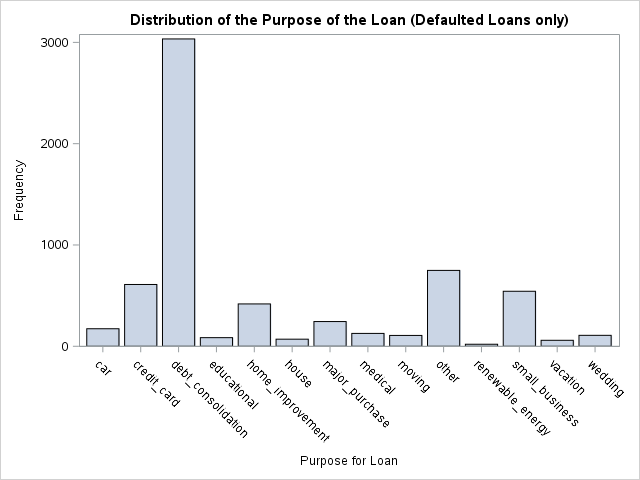
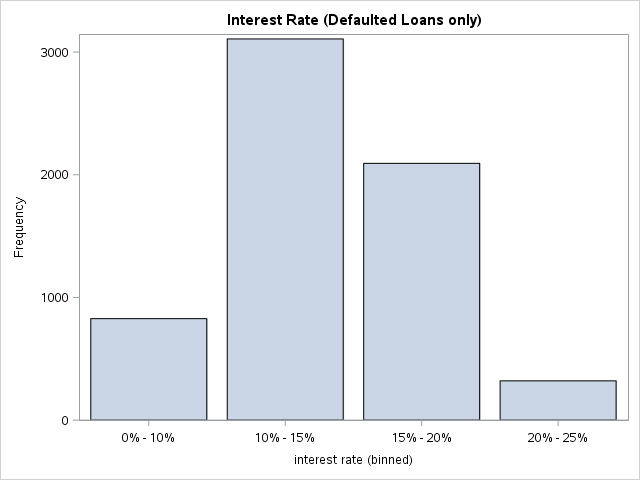
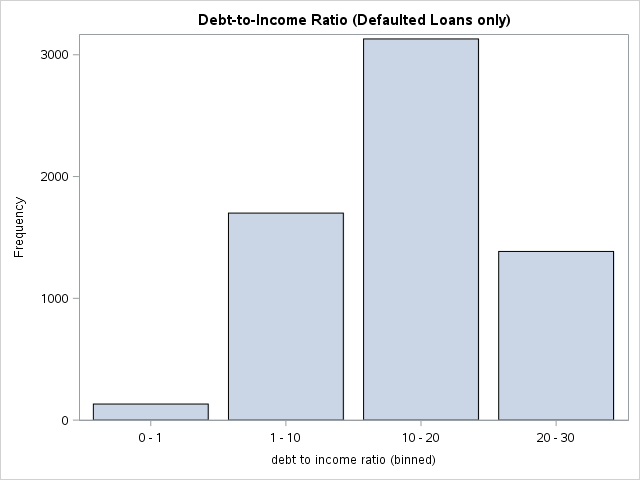
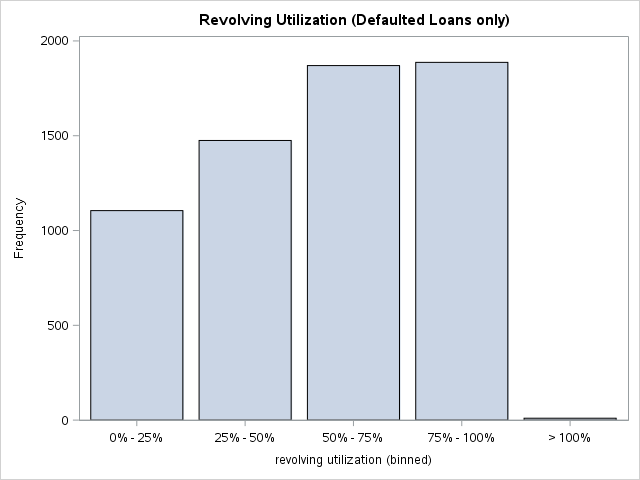

In [5]:
/*  =======================================================
    4. STEP 1 - Create a graph of your variables one at a time
    ======================================================= */
    
/* purpose", int_rate", "dti", "revol_util" and "recoveries"  */

/* BAR PLOT */
proc sgplot data=work.loanstats_defaulted;
    title "Distribution of the Purpose of the Loan (Defaulted Loans only)";
    vbar purpose;
run;
proc sgplot data=work.loanstats_defaulted;
    title "Interest Rate (Defaulted Loans only)";
    vbar int_rate_bin;
run;
proc sgplot data=work.loanstats_defaulted;
    title "Debt-to-Income Ratio (Defaulted Loans only)";
    vbar dti_bin;
run;
proc sgplot data=work.loanstats_defaulted;
    title "Revolving Utilization (Defaulted Loans only)";
    vbar revol_util_bin;
run;

## Univariate Graphs (Distribution)
<a id='distribution_graphs'></a>

[Home](#home_cell)


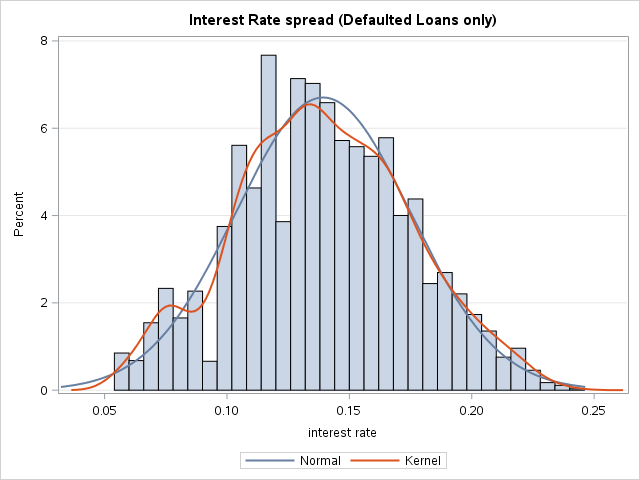
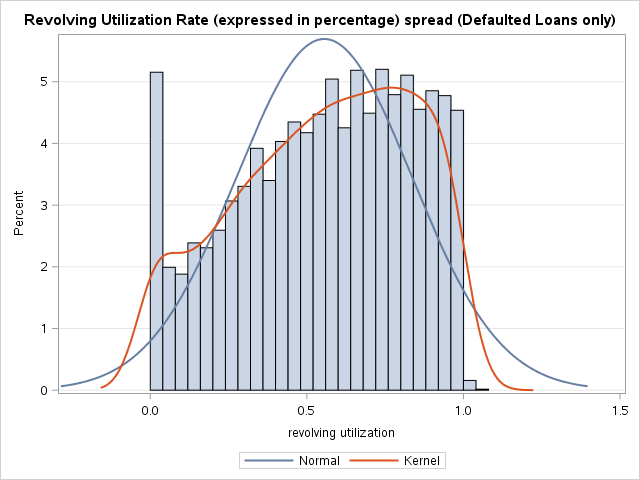
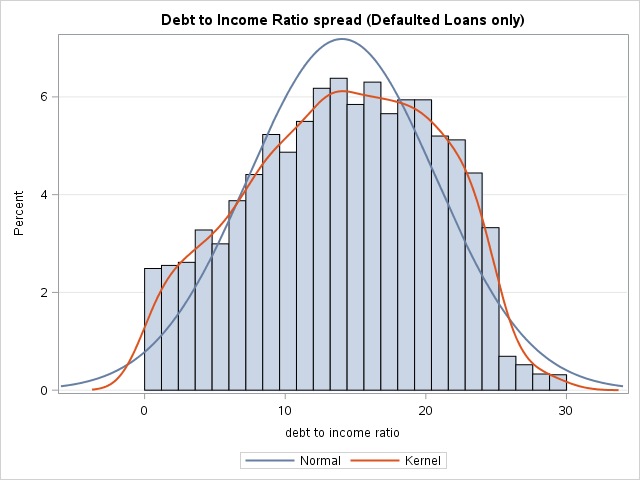
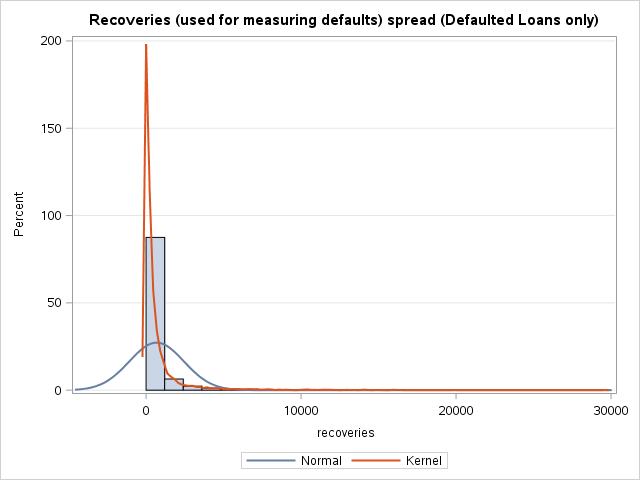

In [6]:
/* Histogram plot */
/* purpose", int_rate", "dti", "revol_util" and "recoveries"  */

proc sgplot data=work.loanstats_defaulted;
    title "Interest Rate spread (Defaulted Loans only)";
    histogram int_rate_d;
    density int_rate_d;
    density int_rate_d / type=Kernal;
    yaxis grid;
run;

proc sgplot data=work.loanstats_defaulted;
    title "Revolving Utilization Rate (expressed in percentage) spread (Defaulted Loans only)";
    histogram revol_util_d;
    density revol_util_d;
    density revol_util_d / type=Kernal;
    yaxis grid;
run;

proc sgplot data=work.loanstats_defaulted;
    title "Debt to Income Ratio spread (Defaulted Loans only)";
    histogram dti;
    density dti;
    density dti / type=Kernal;
    yaxis grid;
run;

proc sgplot data=work.loanstats_defaulted;
    title "Recoveries (used for measuring defaults) spread (Defaulted Loans only)";
    histogram recoveries;
    density recoveries;
    density recoveries / type=Kernal;
    yaxis grid;
run;

## Bivariate Graphs 
<a id='bivariate_graphs'></a>

[Home](#home_cell)


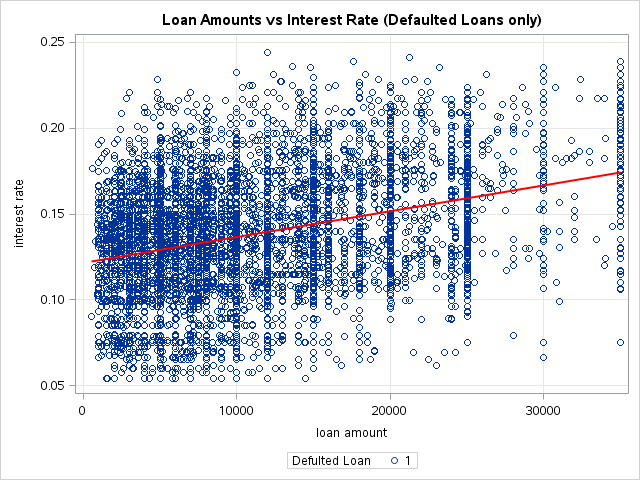
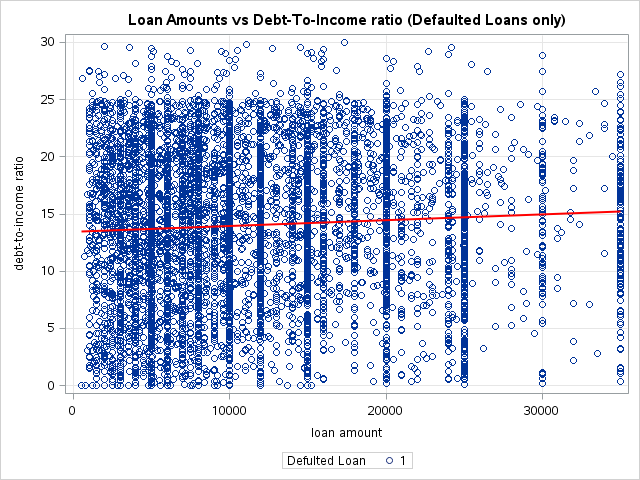
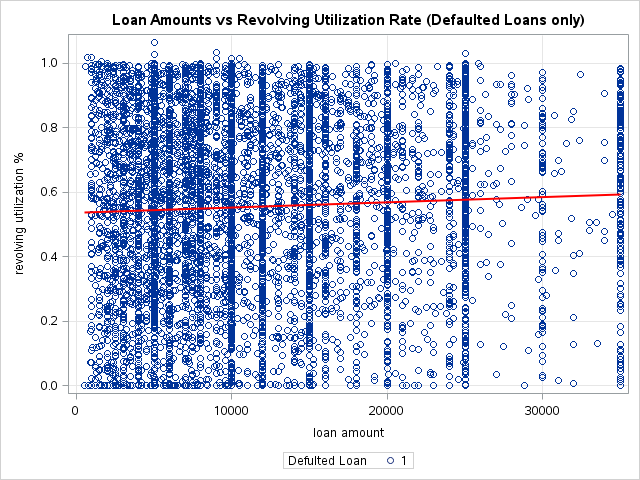

In [7]:
/*  ===========================================================================================
    5. STEP 2 - Create a graph showing association between your explanatory and response variables 
    =========================================================================================== */
    
/* purpose", int_rate", "dti", "revol_util" and "recoveries"  */

/* Plot - this needs some more work */
proc sgplot data=work.loanstats_defaulted;
    title "Loan Amounts vs Interest Rate (Defaulted Loans only)";
    scatter x=loan_amnt y=int_rate_d / group=defaulted transparency=0.0 name='Scatter';
    reg x=loan_amnt y=int_rate_d / lineattrs=(color=red thickness=2);
    xaxis grid label="loan amount";
    yaxis grid label="interest rate";
run;

proc sgplot data=work.loanstats_defaulted;
    title "Loan Amounts vs Debt-To-Income ratio (Defaulted Loans only)";
    scatter x=loan_amnt y=dti / group=defaulted transparency=0.0 name='Scatter';
    reg x=loan_amnt y=dti / lineattrs=(color=red thickness=2);
    xaxis grid label="loan amount";
    yaxis grid label="debt-to-income ratio";
run;

/* Plot - this needs some more work */
proc sgplot data=work.loanstats_defaulted;
    title "Loan Amounts vs Revolving Utilization Rate (Defaulted Loans only)";
    scatter x=loan_amnt y=revol_util_d / group=defaulted transparency=0.0 name='Scatter';
    reg x=loan_amnt y=revol_util_d / lineattrs=(color=red thickness=2);
    xaxis grid label="loan amount";
    yaxis grid label="revolving utilization %";
run;


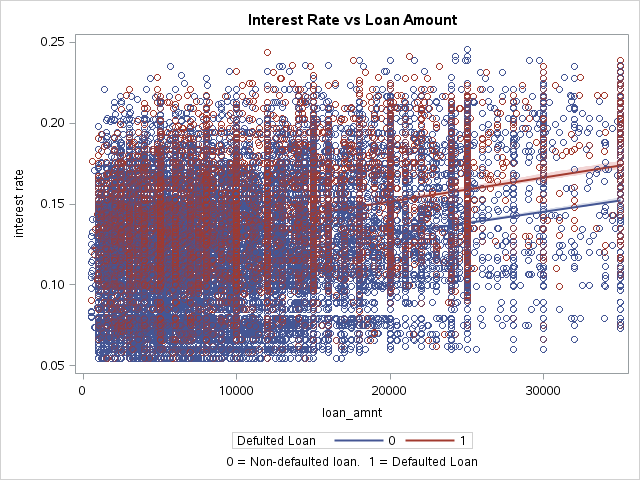

In [8]:
proc sgplot data=work.loanstats;
    title "Interest Rate vs Loan Amount";
    footnote "0 = Non-defaulted loan.  1 = Defaulted Loan";
    reg x=loan_amnt y=int_rate_d / group=defaulted clm clmtransparency=0.75 lineattrs=(pattern=solid);
    scatter x=loan_amnt y=int_rate_d / group=defaulted transparency=0.75 name='Scatter';
run;